In [1]:
import os
os.chdir('/home/xinglong/git_local/dynamax/')

import matplotlib.pyplot as plt

In [4]:
import jax.numpy as jnp
import jax.random as jr
from jax import lax

from dynamax.structural_time_series.models.sts_model import StructuralTimeSeries as STS
from dynamax.structural_time_series.models.sts_components import LocalLinearTrend

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax.distributions import (
    MultivariateNormalFullCovariance as MVN
)


In [149]:
def _build_models(time_steps, key):

    keys = jr.split(key, 5)
    standard_mvn = MVN(jnp.zeros(1), jnp.eye(1))

    # Generate parameters of the STS component
    level_scale = 5
    slope_scale = 0.5
    initial_level = standard_mvn.sample(seed=keys[0])
    initial_slope = standard_mvn.sample(seed=keys[1])

    obs_noise_scale = 20

    # Generate observed time series using the SSM representation.
    F = jnp.array([[1, 1],
                   [0, 1]])
    H = jnp.array([[1, 0]])
    Q = jnp.block([[level_scale, 0],
                   [0, slope_scale]])
    R = obs_noise_scale

    def _step(current_state, key):
        key1, key2 = jr.split(key)
        current_obs = H @ current_state + R * standard_mvn.sample(seed=key1)
        next_state = F @ current_state + Q @ MVN(jnp.zeros(2), jnp.eye(2)).sample(seed=key2)
        return next_state, current_obs

    initial_state = jnp.concatenate((initial_level, initial_slope))
    key_seq = jr.split(keys[2], time_steps)
    _, obs_time_series = lax.scan(_step, initial_state, key_seq)

    # Build the STS model using tfp module.
    tfp_comp = tfp.sts.LocalLinearTrend(observed_time_series=obs_time_series, name='local_linear_trend')
    tfp_model = tfp.sts.Sum([tfp_comp], observed_time_series=obs_time_series)

    # Build the dynamax STS model.
    dynamax_comp = LocalLinearTrend(name='local_linear_trend')
    dynamax_model = STS([dynamax_comp], obs_time_series=obs_time_series)

    # Set the parameters to the parameters learned by the tfp module and fix the parameters.
    tfp_vi_posterior = tfp.sts.build_factored_surrogate_posterior(tfp_model)
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=tfp_model.joint_distribution(obs_time_series).log_prob,
        surrogate_posterior=tfp_vi_posterior,
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        num_steps=200,
        jit_compile=True)
    vi_dists = tfp_vi_posterior.distribution.sample_distributions()
    tfp_params = tfp_vi_posterior.sample(sample_shape=(1,))

    dynamax_model.params['local_linear_trend']['cov_level'] =\
        jnp.atleast_2d(jnp.array(tfp_params['local_linear_trend/_level_scale']**2))
    dynamax_model.params['local_linear_trend']['cov_slope'] =\
        jnp.atleast_2d(jnp.array(tfp_params['local_linear_trend/_slope_scale']**2))
    dynamax_model.params['obs_model']['cov'] =\
        jnp.atleast_2d(jnp.array(tfp_params['observation_noise_scale']**2))

    return (tfp_model, tfp_params,
            dynamax_model, dynamax_model.params,
            obs_time_series,
            vi_dists)

In [150]:
time_steps=150
key=jr.PRNGKey(1)

tfp_model, tfp_params, dynamax_model, dynamax_params, obs_time_series, vi_dists =\
        _build_models(time_steps, key)

tfp_posterior = list(tfp.sts.decompose_by_component(
        tfp_model, obs_time_series, parameter_samples=tfp_params).values())[0]

tfp_forecasts = tfp.sts.forecast(tfp_model, obs_time_series,
                                 parameter_samples=tfp_params,
                                 num_steps_forecast=50,
                                 include_observation_noise=True)

In [151]:
tfp_posterior_mean = jnp.array(tfp_posterior.mean()).squeeze()
tfp_posterior_scale = jnp.array(jnp.array(tfp_posterior.stddev())).squeeze()
tfp_forecast_mean = jnp.array(tfp_forecasts.mean()).squeeze()
tfp_forecast_scale = jnp.array(tfp_forecasts.stddev()).squeeze()

In [152]:
dynamax_posterior = dynamax_model.decompose_by_component(dynamax_params,
                                                             obs_time_series)
dynamax_forecast = dynamax_model.forecast(dynamax_params, obs_time_series,
                                              num_forecast_steps=50)
dynamax_posterior_mean = dynamax_posterior['local_linear_trend']['pos_mean'].squeeze()
dynamax_posterior_cov = dynamax_posterior['local_linear_trend']['pos_cov'].squeeze()
dynamax_forecast_mean = dynamax_forecast['means'].squeeze()
dynamax_forecast_cov = dynamax_forecast['covariances'].squeeze()

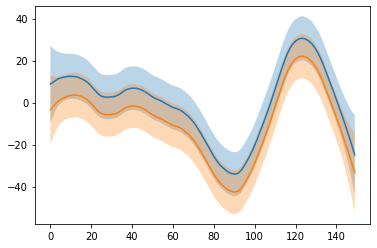

In [153]:
plt.plot(tfp_posterior_mean)

plt.fill_between(jnp.arange(150), tfp_posterior_mean-2*tfp_posterior_scale, tfp_posterior_mean+2*tfp_posterior_scale,
                 alpha=0.3)

plt.plot(dynamax_posterior_mean)
dynamax_posterior_scale = jnp.sqrt(dynamax_posterior_cov)

plt.fill_between(jnp.arange(150), dynamax_posterior_mean-2*dynamax_posterior_scale, dynamax_posterior_mean+2*dynamax_posterior_scale,
                 alpha=0.3)


In [140]:
assert jnp.allclose(tfp_posterior_mean, dynamax_posterior_mean, rtol=1e-1)

AssertionError: 

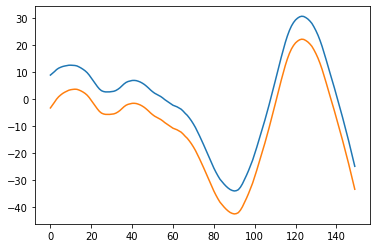

In [154]:
plt.plot(tfp_posterior_mean)
plt.plot(dynamax_posterior_mean)


In [148]:
jnp.abs(obs_time_series[1:] - obs_time_series[:-1]).mean()/5

DeviceArray(4.7737365, dtype=float32)

In [145]:
tfp_forecast_mean - dynamax_forecast_mean

DeviceArray([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e-05, -3.0517578e-05, -3.0517578e-05,
             -3.0517578e

In [ ]:
assert jnp.allclose(tfp_posterior_scale**2, dynamax_posterior_cov, rtol=1e-2)

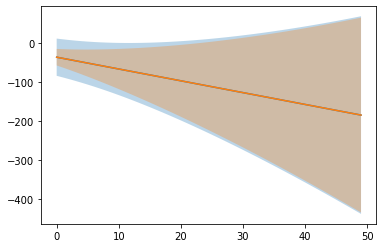

In [155]:
plt.plot(tfp_forecast_mean)
plt.fill_between(jnp.arange(50), tfp_forecast_mean-2*tfp_forecast_scale, tfp_forecast_mean+2*tfp_forecast_scale,
                 alpha=0.3)


plt.plot(dynamax_forecast_mean)
dynamax_forecast_scale = jnp.sqrt(dynamax_forecast_cov)
plt.fill_between(jnp.arange(50), dynamax_forecast_mean-2*dynamax_forecast_scale, dynamax_forecast_mean+2*dynamax_forecast_scale,
                 alpha=0.3)